# ECG Denoising

> We believe we can produce a more robust ECG classifier by learning representations of noisy ECG signals

In [7]:
from pathlib import Path

import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import torch

import os
os.environ["KERAS_BACKEND"] = "torch"

from ecg_classification.preprocessing import SyntheticNoise, preprocess_ecg_signals
from ecg_classification.models import CDAE
from ecg_classification.visualize import plot_ecg, plot_multiple_ecg
from ecg_classification.training import make_ecg_data_train_test_split, print_split_summary

In [2]:
train, test = make_ecg_data_train_test_split(np.load(Path("../data/icentia11k/data.npz")), test_size=0.3, random_state=42)
print_split_summary(train)
print()
print_split_summary(test)

train split (31440, 800)
3525/31440 (0.1121) abnormal beats
34/31440 (0.0011) abnormal rhythms

test split (15720, 800)
46/15720 (0.0029) abnormal beats
277/15720 (0.0176) abnormal rhythms


In [3]:
train.X = preprocess_ecg_signals(train.X)
train.X.shape

(31440, 800)

## Types of Noise

Powerline Interfance

Baseline Wander

Muscle artifacts

In [4]:
syn_noise = SyntheticNoise(random_state=42)

<Axes: xlabel='Time (sec)', ylabel='Amplitude'>

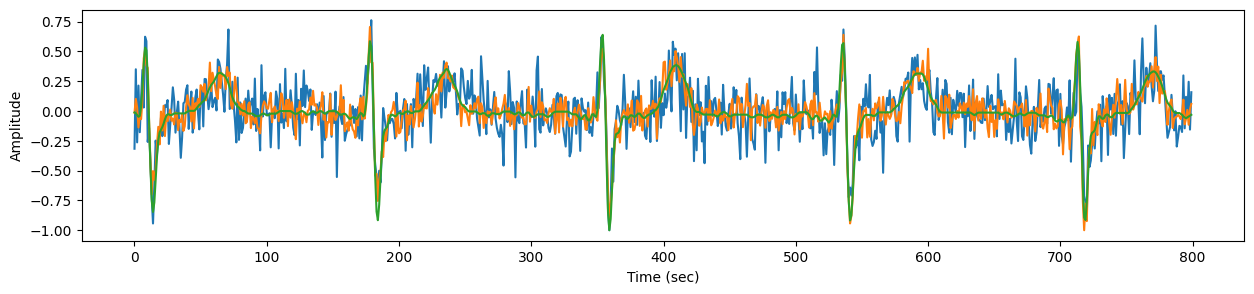

In [9]:
plot_multiple_ecg([
    syn_noise.gaussian_noise(train.X[0].reshape(1, -1), stddev=0.2)[0],
    syn_noise.gaussian_noise(train.X[0].reshape(1, -1), stddev=0.1)[0],
    train.X[0]
])

## CDAE

Convolutional Denoising Autoencoder (CDAE) is models noisy ECG signals by learning to recover a clean ECG signal from a noisified version.

The original paper (Soto & Ashley 2020) that we base our multi-task model architecture on demonstrated good classification performance when the transfered the learned representation of ECG from CDAE to their main model.

In [10]:
cdae = CDAE(input_size=800, models_path=Path("../models"))
cdae.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 800, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 266, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 266, 45)        │        23,085 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 88, 45)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 88, 50)         │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 44, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 44, 50)         │        12,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 88, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 88, 45)         │        18,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 264, 45)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 264, 64)        │        28,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 792, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50688)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 800)            │    40,551,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 800, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,645,748 (155.05 MB)

 Trainable params: 40,645,748 (155.05 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from keras import callbacks

In [12]:
# # Initial learning rate
# initial_lr = 0.01

def lr_schedule(epoch: int, lr: float) -> float:
    if epoch % 25 == 0 and epoch > 0:
        # Make sure the learning rate does not become negative
        return max(lr - 0.001, 0.0001)
    return lr

lr_reduction = callbacks.LearningRateScheduler(lr_schedule, verbose=1)

Cross-Validation

In [24]:
def prep_noisy_dataset(X: npt.NDArray, noise_levels: npt.NDArray, samples_per_level: int) -> npt.NDArray:
    """Creates a dataset of noisy and original signals for use in training a CDAE
    
    Args:
        X: original raw signals, each row is an ECG signal
        noise_levels: levels of noise to apply
        samples_per_level: number of examples per noise level to create
    """
    noise_levels = np.repeat(noise_levels, samples_per_level, axis=0)
    print(noise_levels, len(noise_levels))

    X_noisy = np.concatenate([syn_noise.gaussian_noise(X, lvl) for lvl in noise_levels], axis=0)

    return X_noisy, X

a, b = prep_noisy_dataset(train.X[1:10, 1:5], np.array([0.01, 0.05, 0.1, 0.2]), samples_per_level=2)
a.shape, b.shape

[0.01 0.01 0.05 0.05 0.1  0.1  0.2  0.2 ] 8


((72, 4), (9, 4))

In [ ]:
# Train Autoencoder
history = cdae.fit(
    # The input to the CDAE was the simulated signal dataset
    # with a Gaussian noise factor of 0.001, 0.5, 0.25, 0.75,
    # 1, 2, and 5 added to corrupt the simulated signals.
    x=simulated_noisy_train_data,

    # The uncorrupted simulated signals are then used as the
    # target for reconstruction.
    y=np.tile(train_data, (len(noise_levels), 1, 1)),
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(simulated_noisy_validate_data, np.tile(validate_data, (len(noise_levels), 1, 1))),
    callbacks=[lr_reduction]
)

print(history.history)